# 통매음 프로젝트 

#### 데이터 추출 날짜 : 2025년 5월 3일 

- 기준 : 디씨인사이드에서 "통매음" 검색시 출력되는 300개의 데이터 (2025.03.16 16:32 ~ 2025.05.03 06:17) 
<br>
- 가설 : 디씨인사이드에서 "통매음" 검색시 "게임","욕설","패드립" 같은 주로 미성년자가 게임 중 고소를 언급하는 사례<br> 즉, 부가 가치가 없는 사건이 많을 것이다.

#### 1. 데이터 수집 

- 스크래퍼 만들기
    - 태그 찾기
- HTML 수집과 파싱
    - 함수만들기
#### 2. 데이터 전처리
- 정규 표현식 re
- 람다 함수 lambda
- 날짜형으로 변환 parse
- 요일만 추출 calendar
- 형태소 분석 Kiwi
#### 3. 데이터 분석 
- 다빈도 단어 찾기 Counter().most_common()
- 같이 쓰는 짝궁 단어 nGram
- 특정 단어
- 여러 개의 단어
- 검색시 나오는 단어들의 빈도 시각화 (barchart)
- 주요 키워드 TFIDF
- 상관분석 (시각화, 상관계수)
- PCA 분석 (차원축소)
- KMeans 군집분석 

# 1. 데이터 수집 

## 스크래퍼 만들기

In [3]:
import requests
from bs4 import BeautifulSoup

import time 
import pandas as pd

In [5]:
url = 'https://search.dcinside.com/post/p/{}/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C'

In [6]:
for page in range(1,11): 
    print(url.format(page))

https://search.dcinside.com/post/p/1/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/2/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/3/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/4/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/5/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/6/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/7/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/8/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/9/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C
https://search.dcinside.com/post/p/10/sort/latest/q/.ED.86.B5.EB.A7.A4.EC.9D.8C


## 태그 찾기

게시글 제목 태그는 a.tit_txt <br>
게시글 내용 태그는 a.link_dsc_txt

## HTML 수집과 파싱

In [7]:
response = requests.get(url.format(1))
html = response.text
soup = BeautifulSoup(html, 'lxml')

# print(soup)

# <!DOCTYPE html>
# <html class="darkmode" lang="ko">
# <head>
# <meta charset="utf-8"/>
# <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
# <meta content="kr" name="content-language"/>
# <meta content="8_SyZg2Wg3LNnCmFXzETp7ld4yjZB8ny17m8QsYsLwk" name="google-site-verification"/>
# <meta content="디시인사이드" name="author"/>
# <meta content="디시인사이드 검색결과" name="title"/>
# <meta content="디시인사이드 검색결과" name="description"/>
# <meta content="website" property="og:type"/>
# <meta content="디시인사이드 검색결과" property="og:title"/>
# <meta content="디시인사이드 검색결과" property="og:description"/>
# <meta content="https://nstatic.dcinside.com/dc/w/images/descrip_img.png" property="og:image"/>
# <meta content="https://www.dcinside.com/" property="og:url"/>
# <title>디시인사이드 검색결과</title>
# <!--[if IE 7]>
# 	<link rel="stylesheet" type="text/css" href="https://nstatic.dcinside.com/dc/w/css/ie7.css"/>
# 	<![endif]-->

In [8]:
def find_titles(soup): 
    """게시물 제목을 수집"""
    title_soup = soup.select('a.tit_txt')
    titles = [title.text for title in title_soup]
    return titles

titles = find_titles(soup)
titles[:3]

['폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요??', '롤매음 이제 한물 갔제?', '통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ']

In [10]:
def find_content(soup): 
    """게시물 본문과 게시판&작성일을 수집"""
    content_soup = soup.select('p.link_dsc_txt')
    contents = [content.text for content in content_soup]

    contents_text = []                           # 게시물 본문만 수집 
    etc = []                                     # 그 외 나머지 (게시판명과 작성일을 수집) 
    for idx, content in enumerate(contents):     # enumerate함수로 하나씩 조건문으로 추출 (0, '첫번째값'), (1, '두번째값') 이렇게 추출됨 
        if idx % 2 == 0 :                        # 인덱스를 2로 나누어서 0이 된다면 == 짝수라면 게시물 본문에 수집 
            contents_text.append(content)        
        else:                                    # 인덱스를 2로 나누어서 0이 안된다면 == 홀수라면 그 외 나머지 (게시판명과 작성일)에 수집 
            etc.append(content) 
    return contents_text, etc                    # 이렇게 게시물본문 / 게시판&작성일로 나누어서 별개로 저장 

contents_text, etc = find_content(soup) 

print(contents_text[:6])
print(etc[:6])

['젖었다 박아달라 ㅅㅂ 존나좋다 이런얘기들 캡처랑 대화 저장 다 떠놨고, 통화로도 서로 폰ㅅ 했는데 통매음 고소당할수도 있울까요?? 오츤카톡벙이라 원본방은 나갔습니다 서로 주고받고 했으니 발뻣 가능할까요??', '하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼민이 새끼 같은데 공부나 혀라 이러길레 니애미 보짖살이야 ㅋㅋ틀딱 병신년아 이랬는데 통매음 어쩌구 벌금 200어쩌구 염병 떨던데 걍 무시하면 되는거임?', '', '인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당연히 좋겠지? 나 안 만나볼래 했는데 이걸로 고소를 하겠다네요 이게 통매음에 해당하나요? 인스타 단독도 수사협조가 되나요..?', '분명 음란물 성인인증없이 올리면 걸리는걸로 아는데 ㅇㅇ...', '본문 고발 예시는 통매음인데 끠겨스 고발은 옆에 명예훼손으로 들어가면 됨ㅇㅇ 다들 ㅎㅇㅌ 힘내보자긔']
['통매음2025.05.03 06:17', '통매음2025.05.03 05:33', '서든어택2025.05.03 04:58', '통매음2025.05.03 03:32', '버츄얼 스나2025.05.03 03:06', '피겨스케이팅2025.05.03 02:00']


In [11]:
titles = []
contents = []
etcs = []

for i in range(1, 301): 
    if i % 15 == 0:         # 15 -> 30 등 ... 15단위로만 출력되게 
        print("300p 중 현재 {}페이지".format(i)) 
    
    response = requests.get(url.format(i))
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    title = find_titles(soup)
    content, etc = find_content(soup)

    titles.extend(title) 
    contents.extend(content)
    etcs.extend(etc)

    time.sleep(1)

#################################### 실행하기까지 다소 시간 소요됩니다. 

300p 중 현재 15페이지
300p 중 현재 30페이지
300p 중 현재 45페이지
300p 중 현재 60페이지
300p 중 현재 75페이지
300p 중 현재 90페이지
300p 중 현재 105페이지
300p 중 현재 120페이지
300p 중 현재 135페이지
300p 중 현재 150페이지
300p 중 현재 165페이지
300p 중 현재 180페이지
300p 중 현재 195페이지
300p 중 현재 210페이지
300p 중 현재 225페이지
300p 중 현재 240페이지
300p 중 현재 255페이지
300p 중 현재 270페이지
300p 중 현재 285페이지
300p 중 현재 300페이지


In [52]:
df = pd.DataFrame({
    "게시물제목" : titles, 
    "내용" : contents, 
    "기타 정보" : etcs
})

df

,게시물제목,내용,기타 정보
0,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요??","젖었다 박아달라 ㅅㅂ 존나좋다 이런얘기들 캡처랑 대화 저장 다 떠놨고, 통화로도 서...",통매음2025.05.03 06:17
1,롤매음 이제 한물 갔제?,하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼민이 새끼 같은데 공부나 ...,통매음2025.05.03 05:33
2,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,,서든어택2025.05.03 04:58
3,통매음 도와주세요,인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당연히 좋겠지? 나 ...,통매음2025.05.03 03:32
4,근데 퍼즐 저거 올리는거 통매음에 걸리지않음??,분명 음란물 성인인증없이 올리면 걸리는걸로 아는데 ㅇㅇ...,버츄얼 스나2025.05.03 03:06
...,...,...,...
7495,통매음 고소당한 후기.txt,"정신나간 놈처럼 지독하게, 지속적으로 하지않는 이상 경찰에서 웬만하면 불송치 때리니...",한석원2025.03.16 17:48
7496,우리팀 클대 여자길래 마지막에 섹스하자고하고 왔다,어처피 외국인이라 통매음 알빠노 - dc official App,마블 라이벌즈2025.03.16 17:15
7497,저번에 통매음때린 윤붕이 있냐?,나도 신고넣었다 파일개수 제한 좆같더라 보고있으면 송치여부 언제 연락오는지좀 알려줘라,윤하2025.03.16 16:44
7498,법률 지원으로 돈 벌 수도 있지,통매음 고소하면 수익 더 나올듯 근데 저 조합에 성칭찬이 있던가....?,숲 버츄얼2025.03.16 16:42


# 2. 데이터 전처리

## 정규 표현식 re

In [53]:
############# 정규 표현식으로 원하는 글자만 추출해내는 re 라이브러리
import re 

############# 날짜와 시간만 추출해내는 함수 
def find_date(text) : 
    """날짜만 찾는다"""
    pattern = r"\d+.\d+.\d+"
    result = re.search(pattern, text) 
    date = result.group()
    return date 

def find_time(text) : 
    """시간만 찾는다"""
    pattern = r"\d+:\d+"
    result = re.search(pattern, text)
    time = result.group()
    return time 

############# test 
text = "통매음2025.03.16 14:26"
print(find_date(text=text))
print(find_time(text=text))

2025.03.16
14:26


In [54]:
df['날짜'] = df['기타 정보'].apply(lambda x:find_date(x))
df['작성시간'] = df['기타 정보'].apply(lambda x:find_time(x))
df.head()

,게시물제목,내용,기타 정보,날짜,작성시간
0,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요??","젖었다 박아달라 ㅅㅂ 존나좋다 이런얘기들 캡처랑 대화 저장 다 떠놨고, 통화로도 서...",통매음2025.05.03 06:17,2025.05.03,06:17
1,롤매음 이제 한물 갔제?,하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼민이 새끼 같은데 공부나 ...,통매음2025.05.03 05:33,2025.05.03,05:33
2,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,,서든어택2025.05.03 04:58,2025.05.03,04:58
3,통매음 도와주세요,인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당연히 좋겠지? 나 ...,통매음2025.05.03 03:32,2025.05.03,03:32
4,근데 퍼즐 저거 올리는거 통매음에 걸리지않음??,분명 음란물 성인인증없이 올리면 걸리는걸로 아는데 ㅇㅇ...,버츄얼 스나2025.05.03 03:06,2025.05.03,03:06


In [55]:
###################################### 문자형(str)에서 날짜형(datetime)으로 변경 
from dateutil.parser import parse

date = "2025.04.27"            # str 
dateinfo = parse(date)         # datetime 

print(dateinfo.year)
print(dateinfo.month)
print(dateinfo.day)
###################################### 요일을 나타내는 번호로 변환
import calendar 

calendar.weekday(dateinfo.year, dateinfo.month, dateinfo.day)

# 0 월요일  
# 1 화요일 
# 2 수요일
# 3 목요일
# 4 금요일
# 5 토요일
# 6 일요일
###################################### 요일만 추출하는 함수
def find_day(date): 
    """요일 정보를 반환한다"""
    try : 
        dateinfo = parse(date)

        days = ['월요일','화요일','수요일','목요일','금요일','토요일','일요일']
        day = days[calendar.weekday(dateinfo.year, dateinfo.month, dateinfo.day)]
        return day 
        
    except:                 # 이걸 해줘야 에러 발생시, 코드 실행 중지되지 않고 알수없음으로 반환해줌 
        return "알수없음" 

print(find_day(date="2025.04.27"))
print(find_day(date="2025.04.26"))

2025
4
27
일요일
토요일


In [56]:
df['요일'] = df['날짜'].apply(lambda x:find_day(x))
df['시간대'] = df['작성시간'].apply(lambda x:x.split(":")[0])
df.sample(5)

,게시물제목,내용,기타 정보,날짜,작성시간,요일,시간대
3073,법률 지원으로 돈 벌 수도 있지,통매음 고소하면 수익 더 나올듯 근데 저 조합에 성칭찬이 있던가....?,숲 버츄얼2025.03.16 16:42,2025.03.16,16:42,일요일,16
7414,서든하다가 ㅈ됐다 통매음으로,친구가 공주 이럤는데 공짜로 주는 년 이랬늗네 고소한단다 되냐? 팀챗으로 했다 5명...,통매음2025.03.16 19:11,2025.03.16,19:11,일요일,19
4564,서든하다가 ㅈ됐다 통매음으로,친구가 공주 이럤는데 공짜로 주는 년 이랬늗네 고소한단다 되냐? 팀챗으로 했다 5명...,통매음2025.03.16 19:11,2025.03.16,19:11,일요일,19
4928,서로 쌍욕하다 통매음 고소 당했는데 긴장1도안되노 ㅋㅋ,순경이 언제까지 오라고 했는데 오히려 내가 날짜 앞당김,통매음2025.03.16 23:15,2025.03.16,23:15,일요일,23
4387,통매음 신고할래,내눈,비만2025.03.16 20:23,2025.03.16,20:23,일요일,20


In [57]:
# 게시글 제목과 내용을 합친 새로운 컬럼 만들기
df['모든글자'] = df['게시물제목']+ " " + df['내용']

# 문자열str로 지정
df['모든글자'] = df['모든글자'].astype('str')

# 확인
df.head()

,게시물제목,내용,기타 정보,날짜,작성시간,요일,시간대,모든글자
0,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요??","젖었다 박아달라 ㅅㅂ 존나좋다 이런얘기들 캡처랑 대화 저장 다 떠놨고, 통화로도 서...",통매음2025.05.03 06:17,2025.05.03,06:17,토요일,06,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요?? 젖었다 박아달라 ㅅㅂ 존나좋다 ..."
1,롤매음 이제 한물 갔제?,하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼민이 새끼 같은데 공부나 ...,통매음2025.05.03 05:33,2025.05.03,05:33,토요일,05,롤매음 이제 한물 갔제? 하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼...
2,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,,서든어택2025.05.03 04:58,2025.05.03,04:58,토요일,04,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ
3,통매음 도와주세요,인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당연히 좋겠지? 나 ...,통매음2025.05.03 03:32,2025.05.03,03:32,토요일,03,통매음 도와주세요 인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당...
4,근데 퍼즐 저거 올리는거 통매음에 걸리지않음??,분명 음란물 성인인증없이 올리면 걸리는걸로 아는데 ㅇㅇ...,버츄얼 스나2025.05.03 03:06,2025.05.03,03:06,토요일,03,근데 퍼즐 저거 올리는거 통매음에 걸리지않음?? 분명 음란물 성인인증없이 올리면 걸...


In [58]:
# 그 중에서도 한글만 추출 
df['모든글_한글'] = df['모든글자'].apply(lambda
                           x:" ".join(re.compile("[가-힣]+").findall(x)))
df.head()

,게시물제목,내용,기타 정보,날짜,작성시간,요일,시간대,모든글자,모든글_한글
0,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요??","젖었다 박아달라 ㅅㅂ 존나좋다 이런얘기들 캡처랑 대화 저장 다 떠놨고, 통화로도 서...",통매음2025.05.03 06:17,2025.05.03,06:17,토요일,06,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요?? 젖었다 박아달라 ㅅㅂ 존나좋다 ...",폰 오픈카톡 대화 주고받은거로 통매음 되나요 젖었다 박아달라 존나좋다 이런얘기들 캡...
1,롤매음 이제 한물 갔제?,하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼민이 새끼 같은데 공부나 ...,통매음2025.05.03 05:33,2025.05.03,05:33,토요일,05,롤매음 이제 한물 갔제? 하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼...,롤매음 이제 한물 갔제 하다가 서폿 장애인년이 입 겁나 털고 니 몇살이냐 잼민이 새...
2,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,,서든어택2025.05.03 04:58,2025.05.03,04:58,토요일,04,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,통매음이라 당사자가아니어도 자가고발가능한사안
3,통매음 도와주세요,인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당연히 좋겠지? 나 ...,통매음2025.05.03 03:32,2025.05.03,03:32,토요일,03,통매음 도와주세요 인스타dm으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당...,통매음 도와주세요 인스타 으로 여자애한테 대화중 이상형이 뭐냐고 자지큰 사람이 당연...
4,근데 퍼즐 저거 올리는거 통매음에 걸리지않음??,분명 음란물 성인인증없이 올리면 걸리는걸로 아는데 ㅇㅇ...,버츄얼 스나2025.05.03 03:06,2025.05.03,03:06,토요일,03,근데 퍼즐 저거 올리는거 통매음에 걸리지않음?? 분명 음란물 성인인증없이 올리면 걸...,근데 퍼즐 저거 올리는거 통매음에 걸리지않음 분명 음란물 성인인증없이 올리면 걸리는...


## 형태소 분석 (명사만 추출) 

In [59]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

def find_nouns(text): 
    """입력된 문장에서 명사만 추출하여 리스트로 반환"""
    tokens = kiwi.tokenize(text)  
    return [wrd.form for wrd in tokens if 'NN' in wrd.tag and len(wrd.form) > 1]
    
df['명사'] = df['모든글_한글'].apply(lambda x: find_nouns(x))
df.head(3)

,게시물제목,내용,기타 정보,날짜,작성시간,요일,시간대,모든글자,모든글_한글,명사
0,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요??","젖었다 박아달라 ㅅㅂ 존나좋다 이런얘기들 캡처랑 대화 저장 다 떠놨고, 통화로도 서...",통매음2025.05.03 06:17,2025.05.03,06:17,토요일,06,"폰ㅅ, 오픈카톡 대화 주고받은거로 통매음 되나요?? 젖었다 박아달라 ㅅㅂ 존나좋다 ...",폰 오픈카톡 대화 주고받은거로 통매음 되나요 젖었다 박아달라 존나좋다 이런얘기들 캡...,"[오픈, 카톡, 대화, 매음, 얘기, 캡처, 대화, 저장, 통화, 매음, 고소, 오..."
1,롤매음 이제 한물 갔제?,하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼민이 새끼 같은데 공부나 ...,통매음2025.05.03 05:33,2025.05.03,05:33,토요일,05,롤매음 이제 한물 갔제? 하다가 서폿 장애인년이 입 겁나 털고 ㅅㅂ 니 몇살이냐 잼...,롤매음 이제 한물 갔제 하다가 서폿 장애인년이 입 겁나 털고 니 몇살이냐 잼민이 새...,"[매음, 한물, 서폿, 장애인, 새끼, 공부, 이러길레, 니애미, 보짖살, 병신, ..."
2,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,,서든어택2025.05.03 04:58,2025.05.03,04:58,토요일,04,통매음이라 당사자가아니어도 3자가고발가능한사안ㅋ,통매음이라 당사자가아니어도 자가고발가능한사안,"[매음, 당사자, 자가, 고발, 가능, 사안]"


# 데이터 저장해두기

In [60]:
# df.to_excel('./디씨_통매음_2025년5월3일_3월16일13시42경.xlsx', index=False)
# df.to_csv('./디씨_통매음_2025년5월3일_3월16일13시42경.csv', index=False)

############# 하면 에러남 

# 데이터 불러오기

In [61]:
# import pandas as pd

# df = pd.read_excel('./디씨_통매음_2025년5월3일_3월16일13시42경.xlsx')
# df.head(2)

############# 하면 에러남 

# 3. 데이터 분석 

## 다빈도 단어 찾기

In [62]:
all_nouns = [word for row in df['명사']for word in row]

# all_nouns

# ['오픈',
#  '카톡',
#  '대화',
#  '매음',
#  '얘기',

In [63]:
from collections import Counter

common_words = Counter(all_nouns).most_common()

# common_words

# [('매음', 8141),
#  ('고소', 2404),
#  ('신고', 1518),
#  ('트위터', 1062),
#  ('연락', 956),
#  ('사진', 875),

In [64]:
keys = []
counts = []

keys , counts = zip(*common_words)
key = list(keys)
count = list(counts)

print(key[:3], count[:3])

['매음', '고소', '신고'] [8141, 2404, 1674]


In [65]:
dc_count = pd.DataFrame({"단어":keys, "빈도":counts})
dc_count.head()

,단어,빈도
0,매음,8141
1,고소,2404
2,신고,1674
3,갤러리,819
4,연락,800


In [66]:
dc_count.describe()         # mean 평균 빈도수가 12.6  ----> 평균이상인 13번 등장한 단어들만 따로 모아봐야할 필요 있음

,빈도
count,5239.000000
mean,12.168162
std,127.603280
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,8141.000000


In [67]:
dc_counts = dc_count[dc_count['빈도']>=13]
dc_counts.head(40)                         # 여자, 남자, 재산, 전문, 부모, 생각, 심리, 법률, 가정 , 소송, 분할 , 숙려 등등 

,단어,빈도
0,매음,8141
1,고소,2404
2,신고,1674
3,갤러리,819
4,연락,800
5,트위터,782
6,사진,735
7,여자,679
8,라인,587
9,얼굴,580


## 같이 쓰는 짝궁 단어

In [68]:
# all_nouns

# ['오픈',
#  '카톡',
#  '대화',
#  '매음',
#  '얘기',
#  '캡처',
#  '대화',
#  '저장',

In [69]:
def getGram(tokens , n) : 
    """분절된 단어를 전달하면 nGram을 반환"""
    bigrams = []
    bigrams = [tokens[i:i+n] for i in range(len(tokens)-n+1)]

    ngram_result = pd.DataFrame(data = {'nGram': bigrams})
    ngram_result['nGram'] = ngram_result['nGram'].apply(lambda x : " ".join(x))
    ngram_result = ngram_result['nGram'].value_counts().to_frame()
    ngram_result.reset_index(inplace=True)

    return ngram_result

bigram = getGram(all_nouns, n=2)
bigram

,index,nGram
0,매음 고소,1612
1,매음 신고,1192
2,트위터 라인,550
3,신고 매음,415
4,매음 매음,376
...,...,...
18607,처벌 내용,1
18608,내용 유튜브,1
18609,소름 바린,1
18610,악플 제보,1


In [70]:
bigram100 = bigram[bigram['nGram'] >= 100]
bigram100.head(10)

,index,nGram
0,매음 고소,1612
1,매음 신고,1192
2,트위터 라인,550
3,신고 매음,415
4,매음 매음,376
5,신고 완료,373
6,연락 매음,367
7,얼굴 사진,366
8,마지막 섹스,364
9,외국인 매음,363


In [71]:
# 특정단어

test1 = bigram[bigram['index'].str.contains('트위터')].copy()
test1['test1'] = test1['index'].str.replace('트위터'," ").str.strip()
test1['test1'].value_counts()

매음     2
협조     2
인스타    2
연락     2
질문     2
      ..
접수     1
개조     1
전화     1
궁금     1
상대     1
Name: test1, Length: 80, dtype: int64

In [72]:
# 여러개 단어

words = [
    '성립', '수위', '정도', '특정', 
    '경찰','경찰서', '처벌',  '수사', '송치', '기소','혐의',
    '벌금','합의', '합의금', '피해자',
    '성희롱', '모욕', '명예','협박',
    '게임', '패드립' , '잼민이', '초딩' ,
    '사진', '영상', '인스타','댓글', '채팅', '트위터', '라인', '오픈', '카톡'
]

def label_product(product): 
    """제품 기반으로 문서를 분류"""
    labels = [word for word in words if word in product]
    return "-".join(labels)

In [73]:
df['모든글_한글'] = df['모든글_한글'].astype('str')
df['label'] = df['모든글_한글'].apply(lambda x : label_product(x))
# df['label'].value_counts()       # 이렇게 하면 너무 많으니까 
df['label'].value_counts()[1:21]   # 0번째 인덱스는 합계니까 제외 

성희롱             245
정도              218
경찰              212
특정              205
송치              195
트위터             194
혐의              190
경찰-송치           184
성희롱-영상          183
사진-트위터-라인       181
협박-사진-트위터-라인    181
사진               57
패드립              52
모욕               50
처벌               46
경찰-경찰서           43
성립               41
벌금               34
채팅               31
명예               27
Name: label, dtype: int64

## 단어 빈도 시각화

In [74]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

############################################ 시각화 셋팅 
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
## 폰트 설정 및 마이너스 부호 설정
plt.rc('font', family='NanumSquare') #나눔 글꼴로 설정
#plt.rc('font', family='Malgun Gothic') #맑은 고딕으로 설정
plt.rc('font', family='AppleGothic') #맥
plt.rcParams['axes.unicode_minus'] = False #부호

Text(0.5, 0, '빈도')

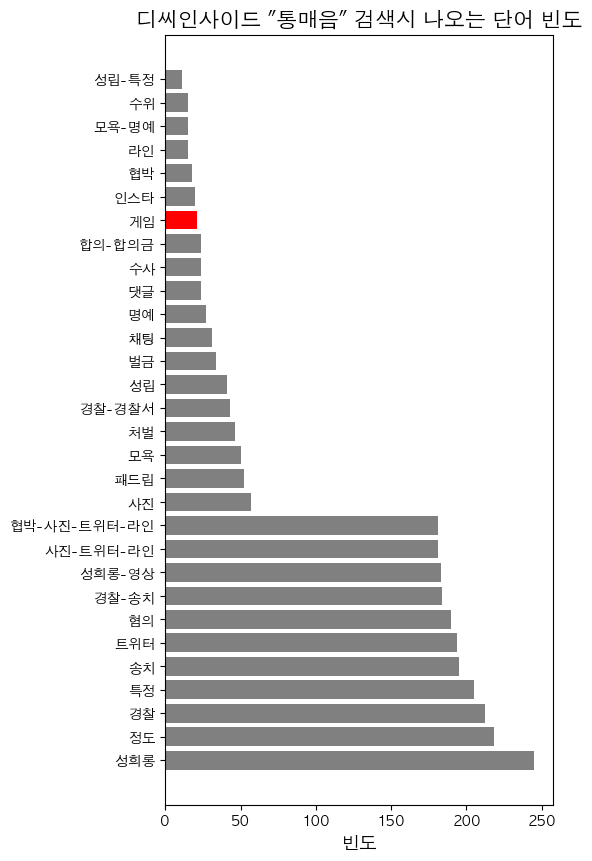

In [75]:
x = df['label'].value_counts()[1:31].index
y = df['label'].value_counts()[1:31].values

# '게임' 인 막대그래프 값만 빨갛게 
colors = ['red' if label == '게임' else 'gray' for label in x]

plt.figure(figsize=(5,10))
plt.title('디씨인사이드 "통매음" 검색시 나오는 단어 빈도', size=15)
# plt.barh(x,y)
plt.barh(x, y, color=colors)
plt.xlabel('빈도', size=13)

## 주요 키워드 TFIDF

In [76]:
# 게임, 패드립,
# 처벌, 수사, 벌금, 경찰, 송치, 기소, 혐의,재판,
# 명예, 명예훼손, 협박, 모욕, 성희롱, 능욕,
# 합의, 피해자, 반성,
# 인스타, 사진, 댓글, 채팅, 트위터, 라인, 오픈', 카톡,
# 성립, 수위, 정도, 특정 ,

In [77]:
# 각자 변수 값들  중에 하나만 있어도 count 
game = " ".join(df[df['모든글_한글'].str.contains('게임|패드립|잼민이|초딩', na=False)]['모든글_한글'].tolist())

police = " ".join(df[df['모든글_한글'].str.contains('처벌|수사|벌금|경찰|송치|기소|혐의|재판', na=False)]['모든글_한글'].tolist())

shame = " ".join(df[df['모든글_한글'].str.contains('명예|명예훼손|협박|모욕|성희롱|능욕', na=False)]['모든글_한글'].tolist())

after = " ".join(df[df['모든글_한글'].str.contains('합의|피해자|반성', na=False)]['모든글_한글'].tolist())

how = " ".join(df[df['모든글_한글'].str.contains('인스타|사진|영상|댓글|채팅|트위터|라인|오픈|카톡', na=False)]['모든글_한글'].tolist())

standard = " ".join(df[df['모든글_한글'].str.contains('성립|수위|정도|특정', na=False)]['모든글_한글'].tolist())

docs = [game, police, shame, after, how, standard]

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit(docs)
tfidf_array = tfidf.transform(docs).toarray()
tfidf_voca = tfidf.vocabulary_

df_tfidf = pd.DataFrame(
    tfidf_array, 
    columns = tfidf_voca, 
    index = [
        "게임 관련",      # game
        "경찰/처벌 대응",        # police
        "명예훼손/모욕/성희롱",     # shame
        "합의 및 피해자 반응",          # after
        "온라인 채널 방식",    # how
        "발언 수위/성립 여부"       # standard
    ]
)
df_tfidf.head(1)

,롤매음,이제,한물,갔제,하다가,서폿,장애인년이,겁나,털고,몇살이냐,...,됐다,공주,이럤는데,공짜로,주는,이랬늗네,고소한단다,팀챗으로,특정잡아서는,안했다
게임 관련,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00541,0.0,0.0,0.0,0.0


In [79]:
df_tfidf.T

,게임 관련,경찰/처벌 대응,명예훼손/모욕/성희롱,합의 및 피해자 반응,온라인 채널 방식,발언 수위/성립 여부
롤매음,0.00000,0.000664,0.000000,0.0,0.000000,0.001031
이제,0.00000,0.000664,0.000000,0.0,0.000000,0.001031
한물,0.00000,0.000000,0.000000,0.0,0.000625,0.001031
갔제,0.00000,0.000000,0.000000,0.0,0.000000,0.001257
하다가,0.00000,0.000000,0.000776,0.0,0.000000,0.000000
...,...,...,...,...,...,...
이랬늗네,0.00541,0.000415,0.000397,0.0,0.000391,0.000644
고소한단다,0.00000,0.000000,0.000636,0.0,0.000625,0.000000
팀챗으로,0.00000,0.000810,0.000000,0.0,0.000000,0.000000
특정잡아서는,0.00000,0.000000,0.000636,0.0,0.000000,0.001031


## 상관분석

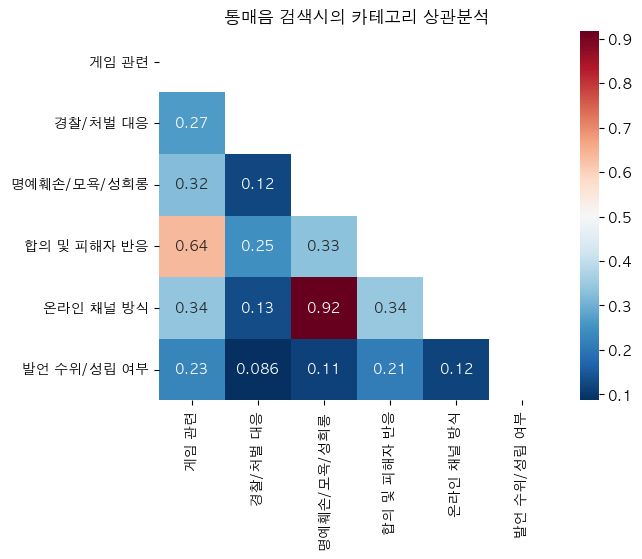

In [80]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

cos_sim = cosine_similarity(df_tfidf)
mask = np.triu(np.ones_like(cos_sim, dtype=bool))    # 절반 가리기 

sns.heatmap(cos_sim, mask = mask , annot=True, xticklabels=df_tfidf.index, yticklabels=df_tfidf.index, cmap="RdBu_r")
plt.title("통매음 검색시의 카테고리 상관분석")
plt.show()

In [81]:
pd.DataFrame(cos_sim, index=df_tfidf.index, columns=df_tfidf.index)

,게임 관련,경찰/처벌 대응,명예훼손/모욕/성희롱,합의 및 피해자 반응,온라인 채널 방식,발언 수위/성립 여부
게임 관련,1.000000,0.267120,0.322190,0.637618,0.337382,0.229028
경찰/처벌 대응,0.267120,1.000000,0.123128,0.246872,0.128782,0.086379
명예훼손/모욕/성희롱,0.322190,0.123128,1.000000,0.332099,0.917967,0.113831
합의 및 피해자 반응,0.637618,0.246872,0.332099,1.000000,0.343081,0.212737
온라인 채널 방식,0.337382,0.128782,0.917967,0.343081,1.000000,0.118335
발언 수위/성립 여부,0.229028,0.086379,0.113831,0.212737,0.118335,1.000000


## 차원축소 PCA 분석

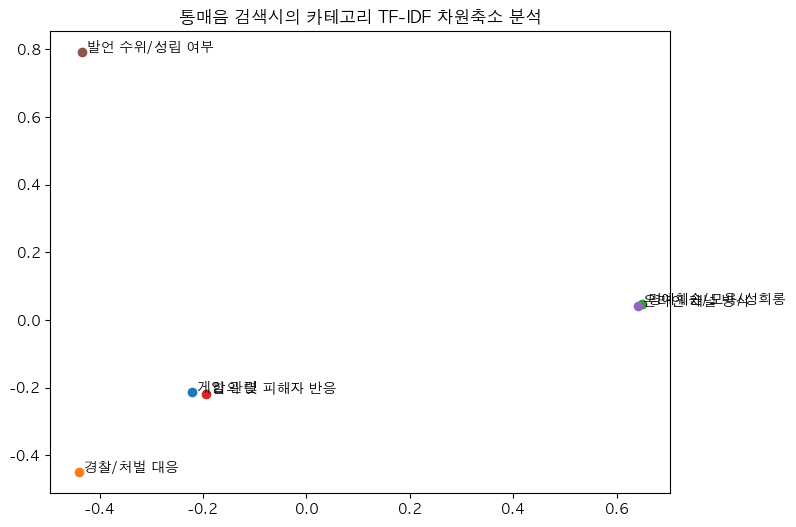

In [82]:
# 6개 카테고리별 유사성 확인 

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(df_tfidf)

plt.figure(figsize=(8, 6))
for i, label in enumerate(df_tfidf.index):
    plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
    plt.text(reduced[i, 0]+0.01, reduced[i, 1], label)

plt.title("통매음 검색시의 카테고리 TF-IDF 차원축소 분석")
plt.show()

## 모든 중요 키워드로 재진행 

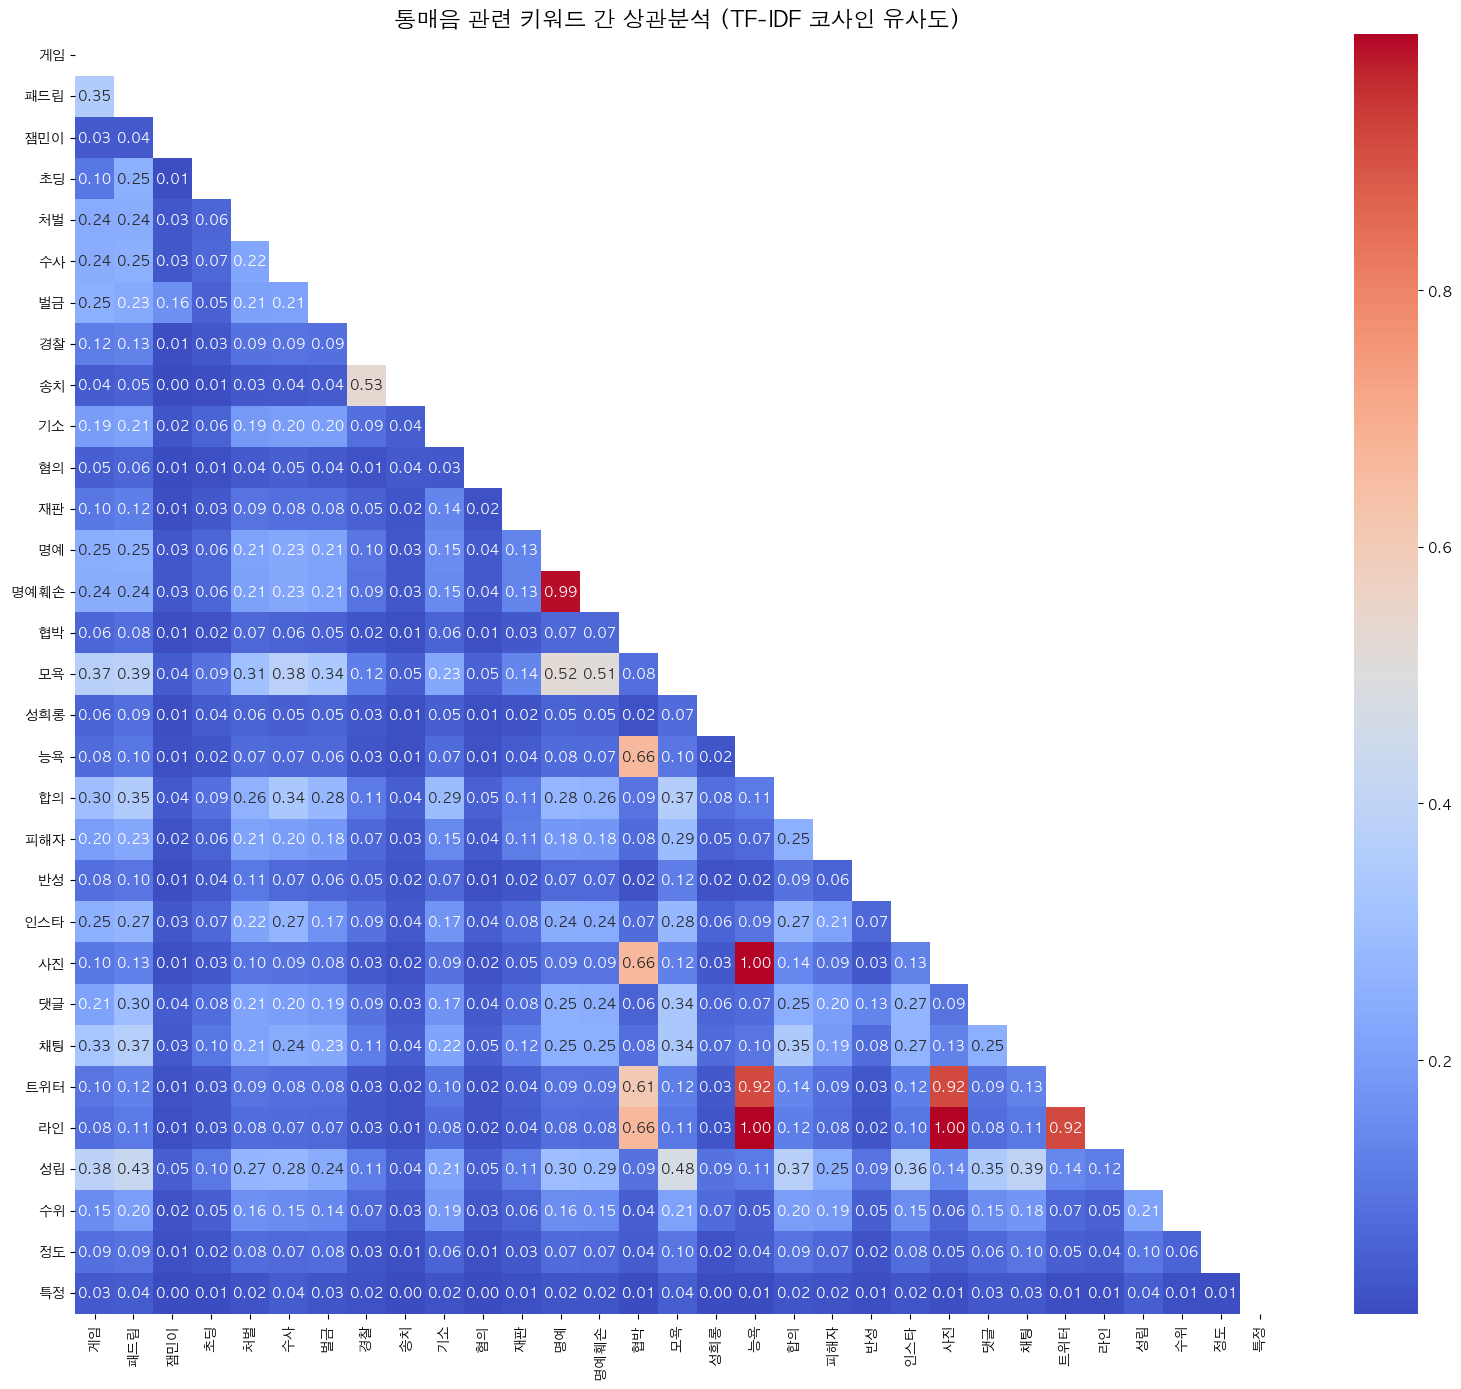

In [83]:
# 키워드 한꺼번에 넣어서 상관분석 

# 1. 키워드 목록
keywords = [
    '게임',  '패드립', '잼민이', '초딩', 
    '처벌', '수사', '벌금', '경찰', '송치', '기소', '혐의','재판',
    '명예', '명예훼손', '협박', '모욕', '성희롱', '능욕',
    '합의', '피해자', '반성', 
    '인스타', '사진', '댓글', '채팅', '트위터', '라인',
    '성립', '수위', '정도', '특정' 
]

# 2. 각 키워드별 텍스트 추출
docs_all = []
valid_keywords = []

for word in keywords:
    filtered_text = " ".join(df[df['모든글_한글'].str.contains(word, na=False)]['모든글_한글'].tolist())
    if filtered_text.strip():  # 내용이 있을 때만 추가
        docs_all.append(filtered_text)
        valid_keywords.append(word)


# 3. TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs_all)

# 4. 코사인 유사도
cos_sim_all = cosine_similarity(tfidf_matrix)

# 5. 상관행렬 시각화
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(cos_sim_all, dtype=bool))

sns.heatmap(cos_sim_all, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=keywords, yticklabels=keywords)
plt.title("통매음 관련 키워드 간 상관분석 (TF-IDF 코사인 유사도)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [84]:
pd.DataFrame(cos_sim_all, index=valid_keywords, columns=valid_keywords).head()

,게임,패드립,잼민이,초딩,처벌,수사,벌금,경찰,송치,기소,...,인스타,사진,댓글,채팅,트위터,라인,성립,수위,정도,특정
게임,1.000000,0.353004,0.033946,0.100199,0.236214,0.241127,0.251634,0.118275,0.040353,0.193822,...,0.248332,0.100072,0.214560,0.326506,0.097982,0.082137,0.384891,0.153923,0.087601,0.034260
패드립,0.353004,1.000000,0.037238,0.254263,0.242629,0.252734,0.232319,0.127332,0.050031,0.210957,...,0.268254,0.125103,0.301557,0.370652,0.123314,0.107614,0.425168,0.198573,0.094425,0.039433
잼민이,0.033946,0.037238,1.000000,0.008161,0.026220,0.027656,0.163558,0.009304,0.004551,0.024690,...,0.028859,0.014063,0.040248,0.034163,0.014344,0.012325,0.047037,0.021165,0.010645,0.002427
초딩,0.100199,0.254263,0.008161,1.000000,0.061394,0.065059,0.051931,0.027985,0.009868,0.056850,...,0.065786,0.030408,0.078121,0.103321,0.030767,0.025914,0.103942,0.046815,0.022167,0.005850
처벌,0.236214,0.242629,0.026220,0.061394,1.000000,0.221481,0.206128,0.088333,0.031478,0.185565,...,0.218263,0.095206,0.214864,0.211078,0.092136,0.078793,0.273389,0.163737,0.077893,0.019862


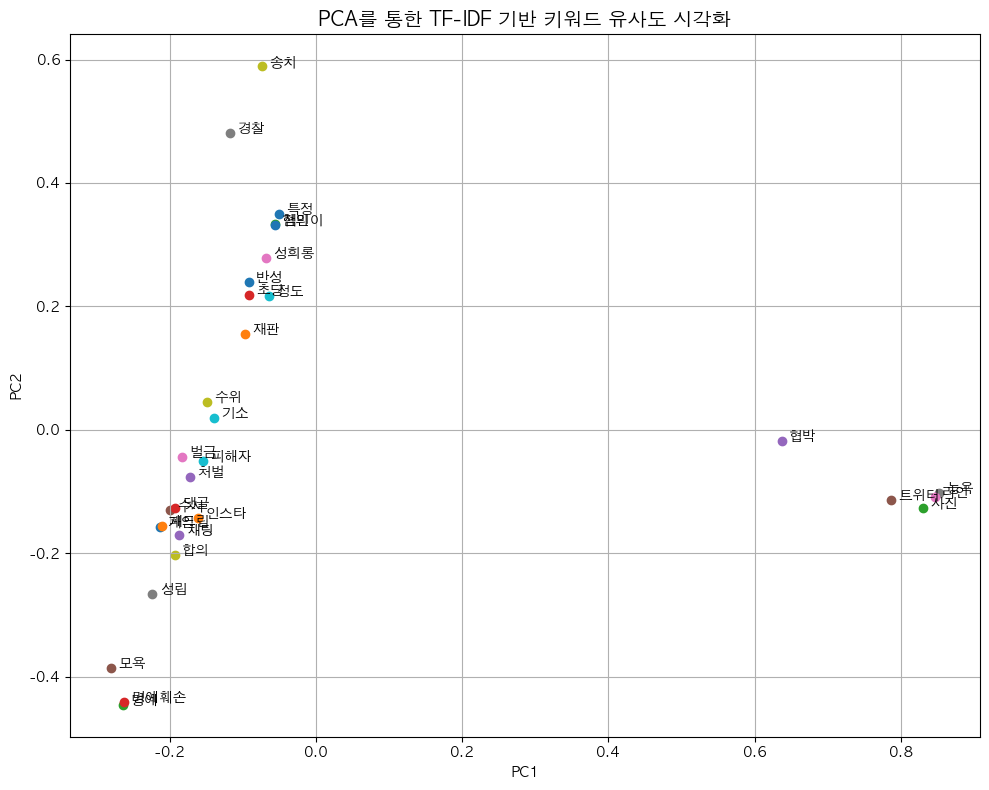

In [85]:
# 차원축소 --> 6개 카테고리별 유사성 확인 

from sklearn.decomposition import PCA

# PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())  # sparse matrix → dense 배열로 변환 필요

# 산점도 시각화
plt.figure(figsize=(10, 8))
for i, label in enumerate(valid_keywords):  # valid_keywords로 사용
    plt.scatter(reduced[i, 0], reduced[i, 1], label=label)
    plt.text(reduced[i, 0] + 0.01, reduced[i, 1], label, fontsize=10)

plt.title("PCA를 통한 TF-IDF 기반 키워드 유사도 시각화", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


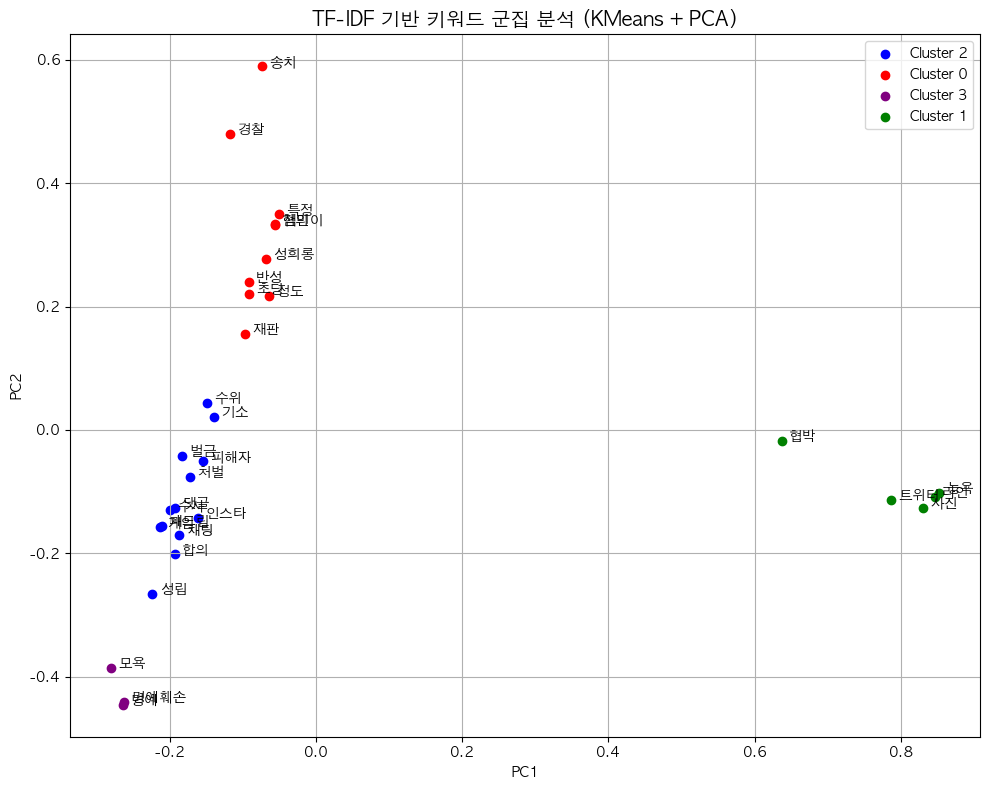

In [86]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

# 2. KMeans 클러스터링 (클러스터 수는 예시로 4개 지정)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(reduced)

# 3. 군집 결과 시각화
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'purple', 'orange']

for i in range(len(reduced)):
    plt.scatter(reduced[i, 0], reduced[i, 1], 
                color=colors[labels[i] % len(colors)], 
                label=f"Cluster {labels[i]}" if f"Cluster {labels[i]}" not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(reduced[i, 0] + 0.01, reduced[i, 1], valid_keywords[i], fontsize=10)

plt.title("TF-IDF 기반 키워드 군집 분석 (KMeans + PCA)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [87]:
from sklearn.cluster import KMeans

# 결과를 DataFrame으로 정리
df_clusters = pd.DataFrame({
    '키워드': valid_keywords,
    '군집번호': labels
})

# 군집번호 기준으로 정렬 (선택사항)
df_clusters = df_clusters.sort_values(by='군집번호').reset_index(drop=True)

print(df_clusters)


     키워드  군집번호
0     특정     0
1    성희롱     0
2     정도     0
3     재판     0
4     혐의     0
5     송치     0
6     경찰     0
7     반성     0
8     초딩     0
9    잼민이     0
10    라인     1
11    사진     1
12    협박     1
13    능욕     1
14   트위터     1
15   인스타     2
16    성립     2
17    댓글     2
18    수위     2
19    채팅     2
20    게임     2
21    합의     2
22    기소     2
23    벌금     2
24    수사     2
25    처벌     2
26   패드립     2
27   피해자     2
28  명예훼손     3
29    명예     3
30    모욕     3
